# Assignment 2: Quantization and Speech Coding
#### EQ2321 Speech and Audio Signal Processing

Max. grade: 50

# Introduction

Throughout this assignment we will use the speech data in `data["speech8"]` which is sampled at 8 kHz. `speech8` will be used both for tuning (training, optimizing) and evaluating the speech coders (evaluating on the training data is called closed test evaluation). Normally this is considered inappropriate (why?), but
we accept it here for simplicity.
You will frequently be asked to evaluate the SNR which is calculated like
$SNR = 10 \log 10 \frac{\sigma_x^2}{\sigma_q^2}$, where $X(n)$ is input speech to the coder, and $q(n) =
X(n) − \hat{X}(n)$ is the quantization error, where $\hat{X}(n)$ is the quantized speech.
Thus, calculating the SNR amounts to estimating $\sigma_x^2$, and $\sigma_q^2$.
Please note that the last part of the assignment may be the most time
consuming. There you are asked to design a forward energy and filter adaptive
DPCM coder and you are not given many instructions. Make sure you allocate
enough time for this last part!

## The Uniform Scalar Quantizer (4 pts)

In this task we implement the simplest quantizer of all: the uniform scalar
quantizer (USQ). USQs will be used frequently in this assignment.
Encoding and transmission by USQ is sometimes called Pulse Code Modulation (PCM).

In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def read_assignment_file(fname):
    with open(fname,"rb") as f:
        d=pkl.load(f)
    return d

assignment_file = "assignment2.pkl"
data=read_assignment_file(assignment_file)

import sounddevice as sd
from scipy.ndimage import median_filter

def play_wav(x,fs):
    sd.play(x.astype(np.int16),fs)

import scipy.signal as si
from scipy.signal import firwin,filtfilt
def lowpass(x,fc,fs=44100):
    """ x is the signal, 
        fc is the cuttoff frequency expressed in Hz, must be between [0,fs/2]
    """
    b = firwin(1024, fc,fs=fs)
    y = filtfilt(b,1,x)
    return y


# the speech data is data["speech8"]

### Question 1（2 pts)

Implement a uniform scalar encoder:

```python
def sq_enc(xin, n_bits, xmax, m):
    """
    xin is a vector with the original speech samples,
    n_bits is the number of bits available to quantize one sample in the quantizer (i.e., the rate),
    xmax and m define the range of the quantizer from m-xmax to m+xmax,
       so that the width of each quantization interval is ∆ = 2 × xmax/L,
           where L is the number of quantization intervals and corresponding reconstruction values.
       m defines the mean (or offset) of the quantizer reconstruction levels.

    The function should return the index of the chosen quantization level.
    """
    return idx
```

Setting m = 0 defines a “midrise” quantizer, and m = $\frac{\Delta}{2}$ gives a "midtread" quantizer (see the course book sec. 7.2).


Implement also the corresponding decoder function
```python
def sq_dec(idx, n_bits, xmax, m)
    """See sq_enc for the definition of the inputs.
    outq is the vector with the quantized values for idx.
    """
    
    return outq
```
The USQ is a highly structured quantizer. The encoder can be imple-
mented essentially by only a scalar division (no multiplications, compar-
isons or loops are needed), making the computational complexity inde-
pendent of the bitrate. Make sure your encoder has a computational
complexity independent of the bitrate!


In [2]:
def sq_enc(xin, n_bits, xmax, m):
    L = 2 ** n_bits  # nr of quant intervals
    delta = 2 * xmax / (L - 1)  # width of each quantization interval
    idx = np.zeros(len(xin))
    
    # Clip values into the range
    x_est = np.clip(xin, -xmax + m, xmax + m)
    
    if m == 0:  # Midrise
        idx = np.round((x_est + xmax) / delta)
    elif m == delta / 2:  # Midtread
        idx = np.round(x_est / delta)
    else:  # Midrise with optional offset
        idx = np.round((x_est - (-xmax + m)) / delta)
    
    return idx.astype(int)

def sq_dec(idx, n_bits, xmax, m):
    L = 2 ** n_bits  # nr of quant intervals
    delta = 2 * xmax / (L - 1)  # width of each quantization interval
    outq = np.zeros(len(idx))
    
    if m == delta / 2:  # Midtread
        outq = (idx-1) * delta
    else:  # Midrise with optional offset
        #outq = (2 * idx - 1) * delta / 2 + (-xmax + m)
        outq = idx * delta - xmax +m
    
    return outq

### Question 2 (2 pts)

Run the encoder and decoder on a ramp signal `x=np.linspace(-6,6,1201)`. Use a `2-bit` quantizer with $x_{max} = 4$. 

Plot the quantizer output as a function of the input. 

Make sure the output levels are exactly where you expect them to be.

Use a quantizer mean $m=0$. Do a similar plot with $m=1.5$.

(-4.0, 4.0)

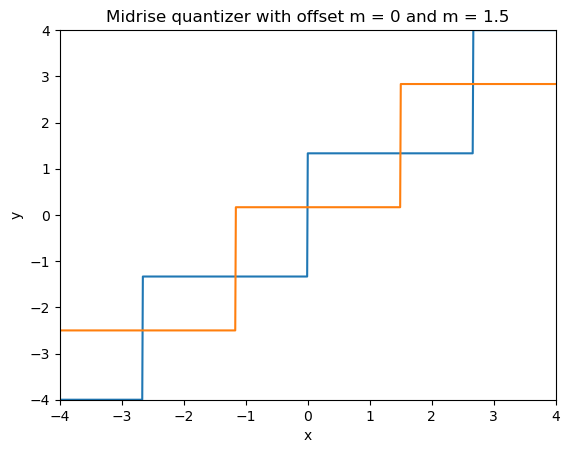

In [3]:
x = np.linspace(-6,6,1201)

y_0 = sq_enc(x, 2, 4, 0)
x_0 = sq_dec(y_0, 2, 4, 0)

y_midrise = sq_enc(x, 2, 4, 1.5)
x_midrise = sq_dec(y_midrise, 2, 4, 1.5)

y_midtreat = sq_enc(x, 2, 4, 4/3)
x_midtreat = sq_dec(y_midrise, 2, 4, 4/3)

plt.plot(x, x_0, x, x_midrise)
plt.title('Midrise quantizer with offset m = 0 and m = 1.5')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-4, 4)
plt.ylim(-4, 4)

In [4]:
out = sq_enc(data['speech8'], 16, 8192, 0)
est = sq_dec(out, 16, 8192, 0)

from scipy.io.wavfile import write
write("est.wav", 8000, est.astype(np.int16))

## Parametric Coding of Speech (23 pts)

In this task we complete our design of the vocoder from assignment 1.
Note that the speech used in this assignment is different from assignment 1 and if
your vocoder analysis is not robust you may have to retune the analysis for this
assignment.
You are encouraged to use your vocoder from assignment 1. This means reuse the functions "analysis"..., "synthesis"...

In practice, a speech coder must operate on a frame-by-frame basis, and transmit compressed data as quickly as possible in order to keep the delay short.
However, you may have implemented your vocoder in an off-line fashion (the pitch estimator is easier to implement like that for example). 


### Quantizing the Frame Energy (8 pts)

In [5]:
from scipy.linalg import solve_toeplitz, toeplitz

def xcorr(x,y,M=10):
    """
    Perform Cross-Correlation on x and y
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation
    corr : coefficients of correlation
    """
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    idx=(lags>=-M) & (lags<=M)
    corr = corr[idx]
    lags=lags[idx]
    return lags[len(lags)//2:], corr[len(lags)//2:]


def analysis(x, alen, ulen, M):
    N = len(x)
    naf = (N-alen+ulen)//ulen
    n1 = 0
    x_reshaped = x.reshape(-1)
    
    # Initialization
    E = np.zeros((naf, 1))
    ZC = np.zeros((naf, 1))
    V = np.zeros((naf, 1))
    A = np.zeros((naf, M+1)) # M is the prediction order.
    # M+1 allows space for the leading 1
    P = np.zeros((naf, 1))
    
    for n in range(naf):
        # Inside loop
        x_frame = x_reshaped[n1:n1+alen] * signal.windows.hann(alen)
        E[n] = np.sum(np.abs(x_frame**2)) / alen
        zc_curr = 0
        for i in range(1,alen):
            if (x_frame[i]*x_frame[i-1]) < 0:
                zc_curr += 1
        ZC[n] =  zc_curr / alen # The normalized number of zero crossings

        lags, r = xcorr(x_frame, x_frame, M)
        a_row = np.concatenate([np.ones((1)), solve_toeplitz(r[:-1], -r[1:])])
        A[n,:] = a_row # Make sure the polynomial coefficients are in a row vector

        lags, r_new = xcorr(x_frame, x_frame, M=(alen-1)) # finding the autocorrelations for the whole analysis frame

        r_peaks, _ = signal.find_peaks(r_new)
        index = np.argmax(r_new[r_peaks])
        P[n] = r_peaks[index]
        
        n1 += ulen

    for n in range(naf):
        thresh = np.average(ZC)
        avg_energy = np.average(E)
        if ZC[n] > thresh and E[n] < 1.5*avg_energy: # product of high zero crossing and low energy is considered to be unvoiced
            V[n] = 0
        else:
            V[n] = 1
        # V[n] =  1 if ZC[n] > thresh else 0 # Equal to 1 if voiced, 0 if unvoiced.
        
    return E, ZC, V, A, P
   

def synthesis(E, ZC, V, A, P, ulen):
    # We have included all the estimated parameters as input arguments but here we only use A!
    n_frames = A.shape[0] # Assuming filter coefficients are stored row-wise
    
    # Create noise excitation:
    # nexc = []
    n1 = 0
    Z = np.array([])
    s = np.zeros((n_frames*ulen))
    
    cnt = 0
    for n in range(0, n_frames):
        # frame wise noise  
        nexc = []
        for f in range(ulen):
            np.random.seed(f+np.random.randint(1))
            rand_noise = np.random.normal(0,2)
            nexc.append(rand_noise)
        # Filter the excitation through the production (vocal tract) filter:      
        # Low pass filter
        if V[n] == 0: #unvoiced
            if Z.shape[0] == 0: # 1st iteration
                s[n1:n1+ulen] = signal.lfilter(np.array([1]), A[n,:], nexc)
                Z = signal.lfiltic(np.array([1]), A[n,:], s[n1:n1+ulen], x=nexc)
            else:
                s[n1:n1+ulen], Z = signal.lfilter(np.array([1]), A[n,:], nexc, zi=Z)
        else: #voiced
            if Z.shape[0] == 0: # 1st iteration
                s[n1:n1+ulen] = signal.lfilter(np.array([1]), A[n,:], nexc)
                Z = signal.lfiltic(np.array([1]), A[n,:], s[n1:n1+ulen], x=nexc)
            else:
                cp = P[n][0]
                pexc = np.zeros(n_frames*ulen)
                pexc[::int(cp)] = 1
                s[n1:n1+ulen], Z = signal.lfilter(np.array([1]), A[n,:], pexc[n1:n1+ulen], zi=Z)
        
        # normalizing wrt energy
        s_frame = s[n1:n1+ulen]
        frame_energy = np.sum(s_frame**2) / len(s_frame)
        factor = 1
        if frame_energy != 0:
            factor = E[n]/frame_energy
        
        s[n1:n1+ulen] = np.sqrt(factor)*s_frame

        n1 += ulen
    return s


energy, zero_crossing, voiced, coeffs, pitch = analysis(data['speech8'], 256, 32, 10)
s = synthesis(energy, zero_crossing, voiced, coeffs, pitch, 32)

#### Question 1 (1 pts)

Provide a plot of the histogram of the energy parameter.
Indicate in the plot the range of the quantizer, i.e., mark the outer boundaries $m\pm xmax$ (also mark m).
Note that the pdf has a non-zero mean.

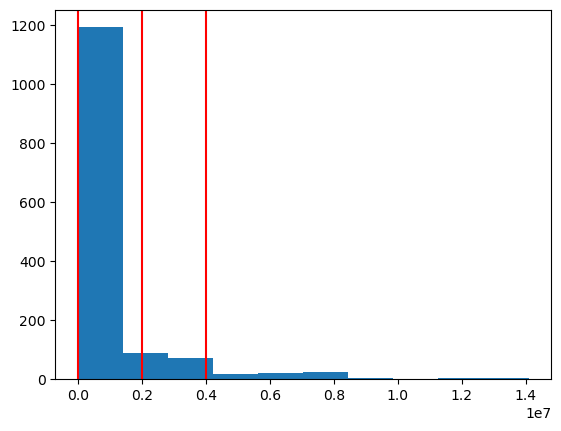

In [6]:
plt.hist(energy)
xmax = 0.4*10**7
m = 0.2*10**7
vertical_line = [0.0, m, xmax]
for line in vertical_line:
    plt.axvline(x = line, color = 'r')
plt.show()

#### Question 2 (2 pts)

Run the vocoder with a uniform scalar energy quantizer according to the design above.
Find the rate at which you cannot hear the quantization distortion.

In [7]:
# change nr of bits
play_wav(s, 8000)

ulen = 32
energy_idx = sq_enc(energy, 6, xmax, m)
quant_energy = sq_dec(energy_idx, 6, xmax, m)
s_e = synthesis(quant_energy, zero_crossing, voiced, coeffs, pitch, ulen)

from scipy.io.wavfile import write
write("est.wav", 8000, s_e.astype(np.int16))

# rate is 6 bits


#### Question 3 (1 pts)

Take the logarithm of the energy parameter prior to quantization (does not matter which base).
Provide a plot of the histogram of the energy parameter in the log-domain.
Indicate the range of this quantizer as above.

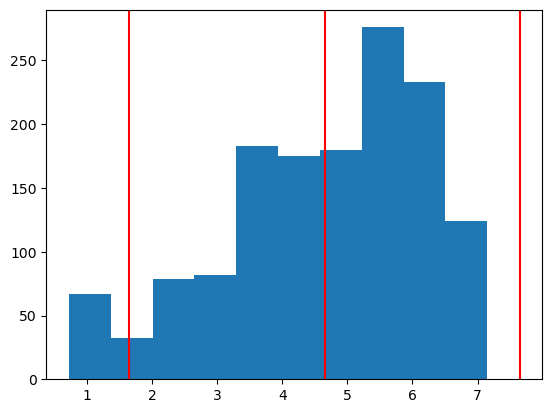

In [8]:
log_energy = np.log10(energy)
plt.hist(log_energy)

# finding mean
m = np.mean(log_energy)
xmax = m+3

vertical_line = [m-3, m, m+3]
for line in vertical_line:
    plt.axvline(x = line, color = 'r')
plt.show()

#### Question 4 (2 pts)

Run the vocoder with a uniform scalar log-energy quantizer according to the design above.
Find the rate at which you cannot hear the quantization distortion.
Make sure to modify the decoder accordingly (apply the exp function to the quantized log-energy).

In [9]:
play_wav(s, 8000)

ulen = 32
energy_log_idx = sq_enc(log_energy, 4, xmax, m)
quant_log_energy = 10**sq_dec(energy_log_idx, 4, xmax, m)
s_log_e = synthesis(quant_log_energy, zero_crossing, voiced, coeffs, pitch, ulen)

from scipy.io.wavfile import write
write("est.wav", 8000, s_log_e.astype(np.int16))

# rate is 4

#### Question 5 (2 pts)

Which is better: energy quantization in linear or log domain?

Parametric Coding of Speech: In this case, logarithmic domain quantization is preferred. Logarithmic quantization allows for a more uniform representation of energy levels across the dynamic range. In linear cases, many values are close to 0.1 * 10^7, making it hard to select the right uniform scaler quantization. In the logarithm domain the energy levels have a wider distribution, so the uniform scaler quantization introduces an error that is significantly lower than what would occur in the linear domain.

### Quantizing the Pitch and Voiced/Unvoiced Decision (2 pts)

#### Question 1 (2 pts)

Come up with an efficient way to encode the pitch and voiced/unvoiced decision.

In [10]:
def encodePitch(V, P, nr_bits):
    quant_P = np.zeros(len(V))
    
    #find falling and raising edges
    raising = []
    falling = []
    
    if V[0] == 1:
        raising.append(0)
    for n in range(len(V)-1):
        if V[n] == 1 and V[n+1] == 0:
            falling.append(n+1)
        if V[n] == 0 and V[n+1] == 1:
            raising.append(n+1)
    if len(raising) > len(falling):
        falling.append(len(V)-1)
        
    # encode pitch
    for n in range(len(raising)):
        section = P[raising[n]:falling[n]]
        m = np.mean(section)
        xmax = max(section)
        quant_P[raising[n]:falling[n]] = np.squeeze(sq_dec(sq_enc(section, nr_bits, xmax, m), nr_bits, xmax, m))
        
    return quant_P.reshape(-1, 1)
    
quant_pitch = encodePitch(voiced, pitch, 5)

s_p = synthesis(energy, zero_crossing, voiced, coeffs, quant_pitch, 32)
from scipy.io.wavfile import write
write("est.wav", 8000, s_p.astype(np.int16))

### Quantizing the LP parameters (4 pts)

#### Question 1 (4 pts)

For the quantization of LP parameters, we will use a vector quantizer (VQ).
You do not need to optimize (train) the VQs; that has been done for you, and
the codebooks can be found in the given data 'lsfCB1' and 'lsfCB2' in
the file assignment2.pkl
The codebooks constitute a multistage VQ. 
`lsfCB1` is a 10 bit VQ optimized on 10 dimensional LSF vectors. 
`lsfCB2` is a 10 bit second stage residual codebook.
You extract these codebooks by calling data['lsfCB1'], data['lsfCB2']

What you need to do is to program an encoding function and a corresponding decoding function for a multistage VQ. 
A suitable calling syntax for these functions can be

```python
def encodefilter(A, cb1, cb2):
    return codeA
```

```python
def decodefilter(codeA, cb1, cb2):
    return Aq
```

Here A is a matrix with filter coefficients stored row-wise, and codeA is a two-column matrix with the corresponding code indices, stored row-wise.

Notes:

1. To convert between polynomial (a-) coefficients and LSFs see `poly2lsf` and `lsf2poly`. You migh require toolboxes such as https://pyspectrum.readthedocs.io/en/latest/install.html

2. `poly2lsf` requires the polynomial coefficients to correspond to a minimum phase whitening filter. 
This is guaranteed by the autocorrelation LP analysis.
`lsf2poly` requires that the LSFs correspond to a minimum phase whitening filter.
The multistage VQ can output LSFs that do not satisfy this.
As a precaution simply sort the LSFs prior to calling `lsf2poly`.
Also check so they are between 0 and $\pi$.

In [11]:
import spectrum as spec

cb1 = data['lsfCB1']
cb2 = data['lsfCB2']

# make sure they are in range
for n in range(len(cb1)):
    for i in range(len(cb1[n])):
        if cb1[n][i] > np.pi:
            cb1[n][i] = np.pi
        if cb1[n][i] < 0:
            cb1[n][i] = 0
        if cb2[n][i] > np.pi:
            cb2[n][i] = np.pi
        if cb2[n][i] < 0:
            cb2[n][i] = 0



def encodefilter(A):
    # convert to lsf
    A_poly = []
    for i in range(len(A)):
        A_poly.append(spec.poly2lsf(A[i]))
    firstStage = []
    eukl = []
    i_first=[]
    j_second=[]
    # First stage encoding
    for n in range(len(A)):
        for i in range(len(cb1)):
            eukl.append(np.linalg.norm(A_poly[n] - cb1[i]))
        i_first.append(np.argmin(eukl))
        firstStage.append(cb1[i_first[n]])
        eukl=[]
        
    
    # Subtract the first stage from A
    res=[]
    for i in range(len(A_poly)):
        res.append(A_poly[i] - firstStage[i])
    
    # Second stage encoding
    secondStage = []
    for n in range(len(res)):
        for i in range(len(cb2)):
            eukl.append(np.linalg.norm(res[n]-cb2[i]))
        j_second.append(np.argmin(eukl))
        secondStage.append(cb2[j_second[n]])
        eukl=[]
    
    codeA = i_first + j_second
    
    return codeA

def decodefilter(codeA):
    
    i_first = codeA[0:len(codeA)//2]
    j_second = codeA[len(codeA)//2:len(codeA)]
    # Initialize decoded filter coefficients array
    dec_A = []
    rec_A = []
    # Inverse the process of encoding
    for n in range(len(codeA)//2):
        # Reconstruct the second stage
        rec_second_stage = np.array(cb2[j_second[n]])

        # Reconstruct the first stage
        rec_first_stage = rec_second_stage + np.array(cb1[i_first[n]])

        # Append the reconstructed filter coefficients to the decoded array
        rec_A.append(rec_first_stage)
        
        
    for i in range(len(rec_A)):
            dec_A.append(spec.lsf2poly(rec_A[i]))
            
    return np.array(dec_A)


codeA = encodefilter(coeffs)
dec_A = decodefilter(codeA)

### Optimizing the Bit Allocation (9 pts)

Here you experiment a little with the number of bits to use for each parameter.
Since you are provided with the LSF codebooks, you cannot experiment with the number of bits spent on LP parameter quantization.
LP quantization contributes a lot to the total number of bits, and the choice of LSF codebook size
vs. performance is crucial in vocoder design, but here we keep the LSF codebook
size fixed.
Find a bit allocation (i.e. the number of bits to use in each quantizer) for the energy, pitch, voiced/unvoiced quantizers, such that the quality is the same as when these parameters are unquantized (the effect of the LP parameter quantization is always present).

#### Question 1 (2 pts)

Evaluate the SNR for your design above.

In [12]:
original = synthesis(energy, zero_crossing, voiced, coeffs, pitch, 32)

# quant_log_energy: 4 bits, quant_pitch: 5 bits
quant_log_energy = 10**sq_dec(sq_enc(log_energy, 8, xmax, m), 8, xmax, m)
quant_pitch = encodePitch(voiced, pitch, 8)

quant = synthesis(quant_log_energy, zero_crossing, voiced, dec_A, quant_pitch, 32)
mse = np.mean((original - quant)**2)

# (SNR) in dB
signal_power = np.mean(original**2)
noise_power = mse
snr_db = 10*np.log10(signal_power/noise_power)
print(snr_db)

-0.2979393681889201


#### Question 2 (3 pts)

What number of bits do you suggest for the pitch? For the energy? For the
voiced/unvoiced decision?

for the voiced/unvoiced decision one bit is enough
we should spend more bits on the pitch, because the pitch frequency compared to energy is more crucial for understanding the content of the speech
In the example above we saw that we can achieve a snr of -0.29 dB with 8 bits for energy and 8 for pitch. However, the output of the synthesis sounds equally well to our ears with only 4 bits for energy and 5 for pitch. The SNR in this case is -2.7dB.


#### Question 3 (2 pts)

What is the rate in bits per sample of your vocoder with the bit allocation
suggested above? In bits per second?

In bits per sample: 4 bits for energy, 5 for pitch, one bit for the voiced/unvoiced decision (we could reduce that be using pitch == 0 as decision for voiced/unvoiced) and the 20 bits for the LP parameters.
That makes 30/256 bits/sample and for fs = 8000 Hz: 8000*30/256 bits/second = 0.937 kbits/second

#### Question 4 (2 pts)

Does it make sense to evaluate SNR here? Why or why not?

Calculating SNR after quantization helps you evaluate how well the quantized signal preserves the original signal quality. However, as seen in our case, it may not fully capture subjective aspects of speech quality. We could not detect any difference from 16 bits spend on energy and pitch vs 9 bits. The SNR droped from -0.29 to -2.7dB.

## Speech Waveform Quantization (10 pts)

#### Uniform Scalar Quantization of Speech

We will in the following design our quantizers using $x_{max} = \sigma_Xk$ , where $\sigma_X$
is the variance of speech and k is an experimentally tuned parameter (here it is tuned to maximize SNR). 

`k` is rate dependent and the SNR optimal `k` for rates 1 to 16 are
```python
l=[0.95, 2.1, ?, 4.95, 6.3, 7.65, 8.85, 9.95, 10.6, 11.0, 11.1, 11.2, 11.15, 11.2,
11.15, 11.15]
```

The optimal (in terms of SNR) value for $R = 3$ is to be found experimentally.
Run the quantizer with different values of k, and measure the SNR, to find the optimal choice.

##### Question 1 (2 pts)

Evaluate the optimal `k` for $R = 3$.

In [13]:
k_values = np.linspace(2.1, 4.95, 56) # the value for the optimal SNR will be in between 2.1 and 4.95

std_signal = np.sqrt(np.var(data['speech8'])) # variance of the speech signal 

# list to store x_max values 
x_max_values = [std_signal * k for k in k_values]

snrs = []
for i in range(len(x_max_values)):
    # estimated signal
    x_hat = sq_dec(sq_enc(data['speech8'], 3, x_max_values[i], 0), 3, x_max_values[i], 0)
    # calculate snr
    mse = np.mean((data['speech8']-x_hat)**2)
    snr = std_signal**2/mse
    snrs.append(snr)
#find optimal
k_opt = k_values[np.argmax(snrs)]

print(k_opt)

3.0327272727272727


##### Question 2 (2 pts)

Run the quantizer at rates [16, 15, 14, . . ., 2, 1], and evaluate the SNR
for each rate.
Provide a plot of the SNR as a function of rate.

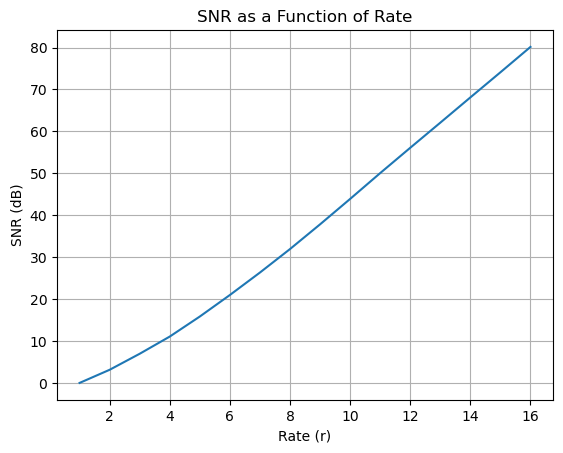

In [14]:
r = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
k_list = [0.95, 2.1, 3.03, 4.95, 6.3, 7.65, 8.85, 9.95, 10.6, 11.0, 11.1, 11.2, 11.15, 11.2, 11.15, 11.15]
x_max_values = [std_signal * k for k in k_list]


snrs = []
for i in range(len(x_max_values)):
    # estimated signal
    x_hat = sq_dec(sq_enc(data['speech8'], r[i], x_max_values[i], 0), r[i], x_max_values[i], 0)
    # calculate snr
    mse = np.mean((data['speech8']-x_hat)**2)
    snr = 10*np.log10(std_signal**2/mse)
    snrs.append(snr)


plt.plot(r, snrs)
plt.xlabel('Rate (r)')
plt.ylabel('SNR (dB)')
plt.title('SNR as a Function of Rate')
plt.grid(True)
plt.show()

##### Question 3 (2 pts)

Provide a graph of the theoretical SNR in the same plot as the experimental SNR plot.
For the theoretical SNR, assume that the number of quantization levels is high, and that overload is negligible.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


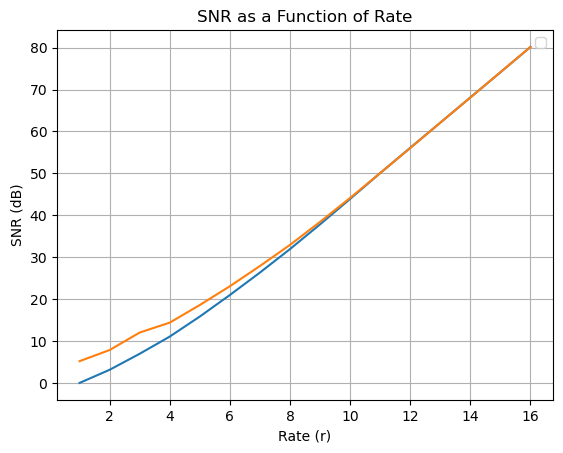

In [15]:
# since in the theoretical there is no overload 

# Define the list to store the optimal k values for each rate
snrs_theory = []

# Iterate over rates from 1 to 16
L = np.array([2 ** rates for rates in r]) # Calculate the number of quantization intervals for the current rate

# calculate theoretical SNR
for i in range(len(x_max_values)):
    delta = 2 * x_max_values[i] / (L[i] - 1)  
    var_q = delta ** 2 / 12
    snrs_theory.append(10 * np.log10(std_signal ** 2 / var_q))

# Plot experimental and theoretical SNR
plt.plot(r, snrs, r, snrs_theory)
plt.xlabel('Rate (r)')
plt.ylabel('SNR (dB)')
plt.title('SNR as a Function of Rate')
plt.legend()  # Show legend to distinguish between theoretical and calculated SNR
plt.grid(True)
plt.show()

##### Question 4 (1 pts)

At what rate can you not tell the difference between the original and the quantized signal?

In [16]:
#play_wav(data['speech8'], 8000)

#i is rate
i = 8
x_hat = sq_dec(sq_enc(data['speech8'], r[i], x_max_values[i], 0), r[i], x_max_values[i], 0)
play_wav(x_hat, 8000)

We cannot tell the difference at rate 8.

##### Question 5 (1 pts)

Listen to the quantization error signal, $q(n)$. 
How would you characterize $q(n)$ for a system operating at rate $R = 1$.
Increase the rate (up to $R \approx 12$) and describe how the character of $q(n)$ changes.

In [17]:
i = 11
x_hat = sq_dec(sq_enc(data['speech8'], r[i], x_max_values[i], 0), r[i], x_max_values[i], 0)
q = data['speech8'] - x_hat

play_wav(q, 8000)

For r = 1 it is mostly noise but one can actually hear the voices and understand some parts.
For r = 12 one cannot hear anything because the residual is very very small.

##### Question 6 (OPTIONAL 2 pts)

Is it advantageous to have a reconstruction level in the origin for low rates?
Compare (by listening) midrise and midtread quantizers at low bit rates.

In [18]:
i = 2
L = 2 ** r[i]
delta = 2 * x_max_values[i] / (L - 1)
x_hat = sq_dec(sq_enc(data['speech8'], r[i], x_max_values[i], delta/2), r[i], x_max_values[i], delta/2)
play_wav(x_hat, 8000)


Using a midtread makes the speech more 'chopped'. Using a midrise introduces the typical noise into the signal. The midtread was for us more pleasant to listen to but the content is worse to understand.

## Adaptive Open-Loop DPCM (13 pts)
<img src="./openloopdcm.png" alt="alt text" width="800"/>

In this section we will study open-loop Differential Pulse Code Modulation (DPCM).
Open loop DPCM can be viewed as pre-filtering, quantization, and post-filtering, see Figure 1 (the adaptation
mechanism is not shown). 
It is called open loop because the quantizer is not part of the prediction loop.

We will want to adapt both the LP coefficients and the energy in a forward fashion.
See the vocoder section for hints on how to forward adapt those.
In general the structure of open loop DPCM is similar to the vocoder structure with
one important difference: vocoders create an artificial replica of the prediction
error signal $d(n)$ (by estimating voiced/unvoiced, the pitch, energy), whereas
open loop DPCM coders quantize each sample of the prediction error signal
and thus try to preserve the original waveform. 

We recommend that you reuse as much as possible of the code from the vocoder.

#### Question 1 (4 pts)
You are not given many guidelines here. Give it your best shot and make
sure you can motivate your choice of for example
- analysis frame length,
- update length (to keep things simple make analysis and update lengths
equal, i.e., no overlapping analysis frames),
- window function (for the analysis of certain parameters),
- number of bits to quantize the energy,
- number of bits to quantize the residual,
Use the VQ as before to quantize the LP parameters (thus, you need not
decide prediction order!).

Design the PCM quantizer for the prediction error d(n) according to
$x_{max} = k \sigma_d$ . 
Optimize k for $R = 3$ (R meaning the rate of the residual quantizer), by experimenting, so that it sounds good, i.e., do not optimize SNR theoretically.

In [19]:
# what do we forward, what do we predict?

# we predict the signal with LP and energy, compute the residual, quantize residual, energy, LP and use that for the synthesis

def DPCM_analysis(x, alen, ulen):
    N = len(x)
    naf = (N-alen+ulen)//ulen
    n1 = 0
    x_reshaped = x.reshape(-1)
    
    # Initialization
    A = np.zeros((naf, 10+1)) # M is the prediction order.
    # M+1 allows space for the leading 1
    x_hat=np.zeros((len(x), 1))
    
    
    for n in range(naf):
        # find frame
        x_frame = x_reshaped[n1:n1+alen] * signal.windows.hann(alen)
        
        lags, r = xcorr(x_frame, x_frame, 10)
        a_row = np.concatenate([np.ones((1)), solve_toeplitz(r[:-1], -r[1:])])
        A[n,:] = a_row # Make sure the polynomial coefficients are in a row vector
        # find x_hat
        x_hat[n1:n1+alen, 0] = signal.lfilter(np.array([1]), A[n,:], x_frame).reshape(-1)
        n1 += ulen
       
    res = x - x_hat
        
    return A, res


alen = 128
ulen = 128

A, res = DPCM_analysis(data['speech8'], alen,ulen)
play_wav(res,8000)


### Quantization


# LP Coefficients
codeA = encodefilter(A)
quant_A = decodefilter(codeA)

# residual

k = 0.8
std_res = np.sqrt(np.var(res))
x_max = k*std_res
quant_res = sq_dec(sq_enc(res, 3, x_max, 0), 3, x_max, 0)


In [20]:
play_wav(data['speech8'], 8000)

In [21]:
play_wav(x_hat, 8000)

In [22]:
play_wav(res, 8000)

In [23]:
def DPCM_synthesis(A, res):
    N = len(x)
    naf = (N-alen+ulen)//ulen
    n1 = 0
    res_reshaped = res.reshape(-1)

    
    # Initialization
    x_tilde=np.zeros((len(res), 1))
    x_rec = np.zeros((len(res), 1))

    for n in range(naf):
        # find frame
        res_frame = res_reshaped[n1:n1+alen] * signal.windows.hann(alen)
        
        # find x_tilde
        x_rec[n1:n1+alen, 0] = signal.lfilter(np.array([1]), A[n,:], res_frame).reshape(-1)
        n1 += ulen
        
    x_tilde = x_rec + res
    return x_tilde

x_est = DPCM_synthesis(quant_A, quant_res)

In [24]:
play_wav(x_est, 8000)

#### Question 2 (1 pts)

Run your system at R = 3. 
How would you characterize the reconstructed speech? What does the quantization error sound like?


In [25]:
error = data['speech8'] - x_est

play_wav(error,8000)

The reconstructed speech sounds noisier than the original but one can understand the speech.
This is also true for the error. This makes sense, because we are using an open-loop system and we have noise shaping.

#### Question 3 (2 pts)

What shape does the quantization error spectrum have? 
Plot a DFT based spectrum of the error for a voiced frame. 
What does theory say?

The spectrum of the reconstruction error should have the same shape as the specturm of the input signal, because 1/(1-A(z)) is the synthesis filter that models the vocal tract. It is called noise shaping and only happens for the open loop DPCM. However, our example does not show that.

c:\Users\there\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


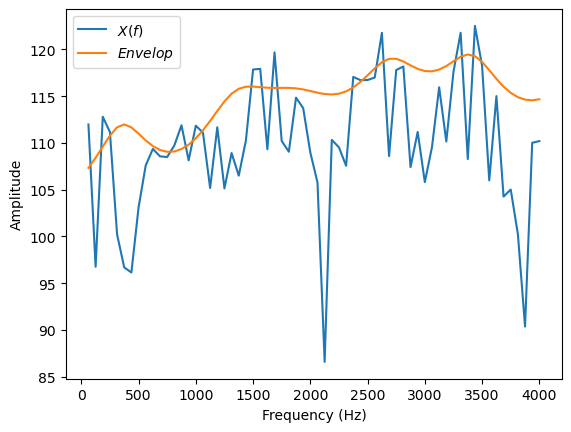

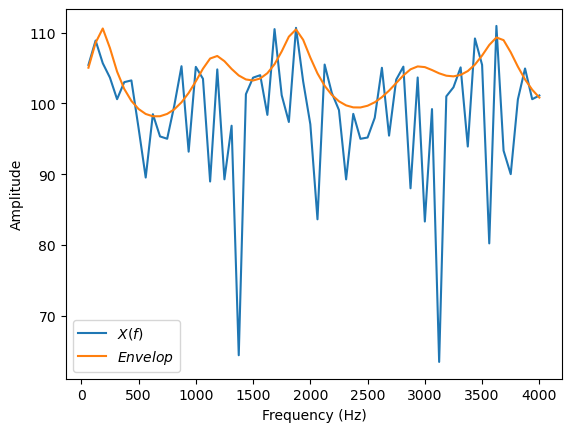

In [26]:
from scipy.fft import fft
def get_envelop(xf,M,N=1024,fs=44100):

    lags, r = xcorr(xf, xf,M=M)

    a=np.concatenate([np.ones(1), solve_toeplitz(r[:-1], -r[1:])]).reshape(-1,1)
    e=(a.T @ r)[0]
    w, h2=signal.freqz(1,a,N,whole=True,fs=fs)
    
    X = fft(xf)
    fig,ax=plt.subplots(1,1)
    
    ax.plot(w[1:N//2+1],10*np.log10(np.abs(X[1:N//2+1])**2),label="$X(f)$")
    ax.plot(w[1:N//2+1],10*np.log10(e*np.abs(h2[1:N//2+1])**2),label="$Envelop$")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.legend()
    return fig,ax


e = error[21*alen:22*alen].reshape(-1)
x = data['speech8'][21*alen:22*alen].reshape(-1)

fig,ax=get_envelop(fft(e),10,alen,8000)

fig,ax=get_envelop(fft(x),10,alen,8000)

#### Question 4 (2 pts)

Measure the SNR of your system. 
Compare with the SNR of PCM at the same rate.
Comments?

In [27]:
mse = np.mean((data['speech8']-x_est)**2)
snr = 10*np.log10(std_signal**2/mse)
print(snr)

-12.008822004545468


The SNR of -11.72 dB is way lower than the previous SNR or -2.67 dB. For the open loop there is no SNR improvement expected.

#### Question 5 (2 pts)

What is the total rate of your coder in bits per sample? In bits per second?

We use 20 bits for the LP coefficents and 3 for the residual. That is a total of 23/128 bits/sample. With a sampling frequency of 8000 Hz that results in 23/128*8000 bits/s = 1.437 kbits/s

#### Question 6 (2 pts)

Is it better to use the quantized LP coefficients in the encoder filter than to use the unquantized LP coefficients?

The output sounds better with unquantized LP coefficients, but of course that is not possible without extreme loss of efficiency.